# Socioeconomic Dataset

In [1]:
import pandas as pd
economics = pd.read_excel('ECONOMICS.xlsx')
economics.head()

,year,dc_class,dc,dc_eng,dc_chi,dh,dhz_1,dhz_2,dhz_3,dhz_4,...,lfpr_age_3_m_xfdh,lfpr_age_4_m_xfdh,lfpr_age_5_m_xfdh,lfpr_age_6_m_xfdh,lfpr_age_1_f_xfdh,lfpr_age_2_f_xfdh,lfpr_age_3_f_xfdh,lfpr_age_4_f_xfdh,lfpr_age_5_f_xfdh,lfpr_age_6_f_xfdh
0,2016,A,11,Central and Western,中西區,84700,18800,26100,15400,14400,...,93.7,97.4,93.0,51.3,38.3,75.4,84.0,72.0,71.2,25.4
1,2016,B,12,Wan Chai,灣仔區,65300,17200,17400,13200,9600,...,97.7,96.4,93.8,50.9,42.9,74.2,86.2,67.7,69.0,23.9
2,2016,C,13,Eastern,東區,186700,33100,48700,43800,37300,...,95.1,97.8,91.8,42.5,40.1,76.9,85.6,75.1,71.8,21.7
3,2016,D,14,Southern,南區,84900,12500,20800,20400,18800,...,97.4,96.6,95.5,47.0,36.4,73.4,82.2,69.7,69.8,24.2
4,2016,E,27,Yau Tsim Mong,油尖旺區,126400,31000,38400,24100,20100,...,90.9,94.5,92.1,51.1,38.6,70.5,74.5,63.5,73.3,25.4


In [2]:
df_economics = pd.DataFrame(economics)
# Specify the columns to keep
columns_to_keep = ['year', 'dc_eng', 'ma_hh']

# Create a new DataFrame with only the specified columns
df_economics = df_economics[columns_to_keep]

In [4]:
# Separate DataFrame by year
years = df_economics['year'].unique()

for year in years:
    # Create a variable name dynamically
    globals()[f'df_economics_{year}'] = df_economics[df_economics['year'] == year].drop(columns=['year']).set_index('dc_eng')

In [5]:
sorted_df_economics_2022 = df_economics_2022.sort_values(by='ma_hh', ascending=False)
sorted_df_economics_2022.rename(columns={'ma_hh': 'income median'}, inplace=True)
sorted_df_economics_2022.columns

Index(['income median'], dtype='object')

In [6]:
population_density = pd.read_excel('POPULATION_2022.xlsx')

In [8]:
df_population_density = pd.DataFrame(population_density)
# Specify the columns to keep
columns_to_keep = ['DC_ENG', 'POPN_D']

# Create a new DataFrame with only the specified columns
df_population_density = df_population_density[columns_to_keep]
df_population_density = df_population_density.iloc[:-1]

sorted_df_population_density = df_population_density.sort_values(by='POPN_D', ascending=False)
sorted_df_population_density.rename(columns={'POPN_D': 'Population Density'}, inplace=True)

sorted_df_population_density

,DC_ENG,Population Density
8,Kwun Tong,59340
5,Sham Shui Po,46220
7,Wong Tai Sin,43480
4,Yau Tsim Mong,42400
6,Kowloon City,40310
2,Eastern,28810
9,Kwai Tsing,21040
0,Central and Western,17820
1,Wan Chai,14970
15,Sha Tin,10020


# MTR

## Data Acquisition

In [9]:
import pandas as pd

mtr_routes = pd.read_csv('mtr_lines_fares.csv')


edge_mtr_routes = pd.read_csv('MTR_Edges_Data.csv')

## Data Cleaning

In [10]:
#Select factors
mtr_routes = mtr_routes[['SRC_STATION_NAME', 'DEST_STATION_NAME', 'OCT_ADT_FARE']]

In [11]:
#This is to use the edges to find distances to all stations
#This is used when revising the modeling
import pandas as pd
import networkx as nx

G = nx.Graph()

for _, row in edge_mtr_routes.iterrows():
    G.add_edge(row['start_eng'], row['end_eng'], weight=row['edge_distance_km'])

stations = sorted(list(G.nodes()))

pairs = [(source, target) for source in stations for target in stations]


results = []
for source, target in pairs:
    if source == target:
        distance = 0
    else:
        try:
            distance = nx.shortest_path_length(G, source=source, target=target, weight='weight')
        except nx.NetworkXNoPath:
            distance = float('inf')
    results.append({'source': source, 'target': target, 'total_distance': distance})


mtr_edge_distances = pd.DataFrame(results)

In [12]:
mtr_edge_distances = mtr_edge_distances.rename(columns={"source": "SRC_STATION_NAME", "target": "DEST_STATION_NAME", "total_distance": "distance_km"})

### Coordinate collection from Wikipedia

In [415]:
pip install wikipedia

Note: you may need to restart the kernel to use updated packages.


In [416]:
import wikipedia
import numpy as np
import requests
import re
import time
from bs4 import BeautifulSoup
import pandas as pd

# URL of the Wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_MTR_stations'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find all tables on the page
tables = soup.find_all('table', class_='wikitable')

# Initialize a list to store all links
all_links = []

# Loop through each table
for table in tables:
    # Find all links in the current table
    links = table.find_all('a')
    for link in links:
        href = link.get('href')
        if href and href.startswith('/wiki/') and not href.startswith('/wiki/File') and 'station' in href:
            all_links.append('https://en.wikipedia.org' + href)
all_links = list(dict.fromkeys(all_links))
link_dataframe = pd.DataFrame(all_links, columns=['Numbers'])

coordinates = []
for link in all_links:
    time.sleep(1)
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')

    geo_span = soup.find('span', class_='geo-dec')
    if geo_span:
      coords = geo_span.text.strip()
      lat, lon = re.findall(r'[\d.]+', coords)[:2]
      if 'S' in coords: lat = '-' + lat
      if 'W' in coords: lon = '-' + lon
      coordinates.append([lat, lon])
      continue

    geo_span = soup.find('span', class_='geo')
    if geo_span:
      lat, lon = geo_span.text.split('; ')
      coordinates.append([lat, lon])
      continue

    infobox = soup.find('table', class_='infobox')
    if infobox:
      for row in infobox.find_all('tr'):
        if 'Coordinates' in row.text:
            coords = row.find('span', class_='geo-dec') or row.find('span', class_='geo')
            if coords:
                if 'geo-dec' in coords.get('class', []):
                    coords_text = coords.text.strip()
                    lat, lon = re.findall(r'[\d.]+', coords_text)[:2]
                    if 'S' in coords_text: lat = '-' + lat
                    if 'W' in coords_text: lon = '-' + lon
                    coordinates.append([lat, lon])
                else:
                    lat, lon = coords.text.split('; ')
                    coordinates.append([lat, lon])
                break

coordinates_dataset = pd.DataFrame(coordinates, columns=['Lat', 'Long'])
link_dataframe = link_dataframe.join(coordinates_dataset)

In [ ]:
#This code just in case the above code doesnt work, since sometimes too many requests are sent.
#It results in the same dataset
link_dataframe = pd.read_csv('wikipedia_coordinates.csv')

In [14]:
link_dataframe = link_dataframe.drop_duplicates(keep='first')
link_dataframe['English Name'] = link_dataframe['Numbers'].str.split('/wiki/').str[-1].str.replace(r'(_station.*|_st.*)', '', regex=True).str.replace('_', ' ')
mtr_coords = link_dataframe.drop('Numbers', axis =1)


In [15]:
# Merge to get source station latitude and longitude
mtr_routes = mtr_routes.merge(mtr_coords, left_on='SRC_STATION_NAME', right_on='English Name', how='left', suffixes=('', '_source'))
mtr_routes = mtr_routes.rename(columns={'Lat': 'source_latitude', 'Long': 'source_longitude'})
mtr_routes = mtr_routes.drop(columns='English Name')

# Merge to get destination station latitude and longitude
mtr_routes = mtr_routes.merge(mtr_coords, left_on='DEST_STATION_NAME', right_on='English Name', how='left', suffixes=('', '_source'))
mtr_routes = mtr_routes.rename(columns={'Lat': 'destination_latitude', 'Long': 'destination_longitude'})
mtr_routes = mtr_routes.drop(columns='English Name')

## Finding districts of stations

In [16]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json

mtr_routes = mtr_routes.dropna()

with open('hksar_18_district_boundary.json', 'r', encoding='utf-8') as file:
    json_data = json.load(file)


district_data = []
for feature in json_data['features']:
    district_name = feature['properties']['District']
    coords = feature['geometry']['coordinates'][0]
    district_data.append({
        "District": district_name,
        "coordinates": [(lon, lat) for lon, lat in coords]
    })


district_polygons = []
for district in district_data:
    coords = district['coordinates']
    polygon = Polygon(coords)
    district_polygons.append((district['District'], polygon))


gdf_districts = gpd.GeoDataFrame(district_polygons, columns=['District', 'geometry'])


geometry = [Point(lon, lat) for lon, lat in zip(mtr_routes['source_longitude'], mtr_routes['source_latitude'])]
gdf_stops = gpd.GeoDataFrame(mtr_routes, geometry=geometry)


gdf_stops['District'] = None
for idx, stop in gdf_stops.iterrows():
    point = stop.geometry
    for _, district in gdf_districts.iterrows():
        if district.geometry.contains(point):  # Check if the point is in the polygon
            gdf_stops.at[idx, 'source_district'] = district['District']
            break


mtr_routes = gdf_stops[['SRC_STATION_NAME','DEST_STATION_NAME','OCT_ADT_FARE', 'source_longitude', 'source_latitude', 'source_district', 'destination_longitude', 'destination_latitude']]

gdf_districts = gpd.GeoDataFrame(district_polygons, columns=['District', 'geometry'])


geometry = [Point(lon, lat) for lon, lat in zip(mtr_routes['destination_longitude'], mtr_routes['destination_latitude'])]
gdf_stops = gpd.GeoDataFrame(mtr_routes, geometry=geometry)


gdf_stops['District'] = None
for idx, stop in gdf_stops.iterrows():
    point = stop.geometry
    for _, district in gdf_districts.iterrows():
        if district.geometry.contains(point):  # Check if the point is in the polygon
            gdf_stops.at[idx, 'destination_district'] = district['District']
            break

mtr_routes = gdf_stops[['SRC_STATION_NAME','DEST_STATION_NAME','OCT_ADT_FARE', 'source_longitude', 'source_latitude', 'source_district', 'destination_longitude', 'destination_latitude', 'destination_district']]


In [ ]:
#Distance calculation
from geopy.distance import geodesic
def calculate_distance(row):
    source_coords = (row['source_latitude'], row['source_longitude'])
    dest_coords = (row['destination_latitude'], row['destination_longitude'])
    return geodesic(source_coords, dest_coords).kilometers
mtr_routes['distance_km'] = mtr_routes.apply(calculate_distance, axis=1)


## EDA

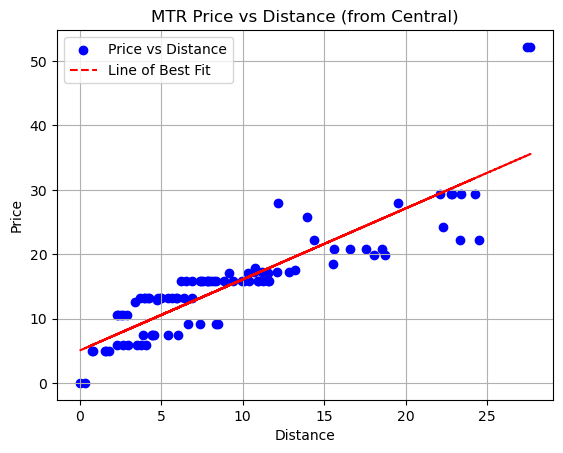

In [18]:
#Simple plotting of distance and price
import matplotlib.pyplot as plt
import numpy as np
central_routes = mtr_routes[mtr_routes['SRC_STATION_NAME'] == 'Central']
plt.scatter(central_routes['distance_km'], central_routes['OCT_ADT_FARE'], color='blue', label='Price vs Distance')

z = np.polyfit(central_routes['distance_km'], central_routes['OCT_ADT_FARE'], 1)
p = np.poly1d(z)


plt.plot(central_routes['distance_km'], p(central_routes['distance_km']), color='red', linestyle='--', label='Line of Best Fit')

plt.title('MTR Price vs Distance (from Central)')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.show()

Text(95.72222222222221, 0.5, 'Source District')

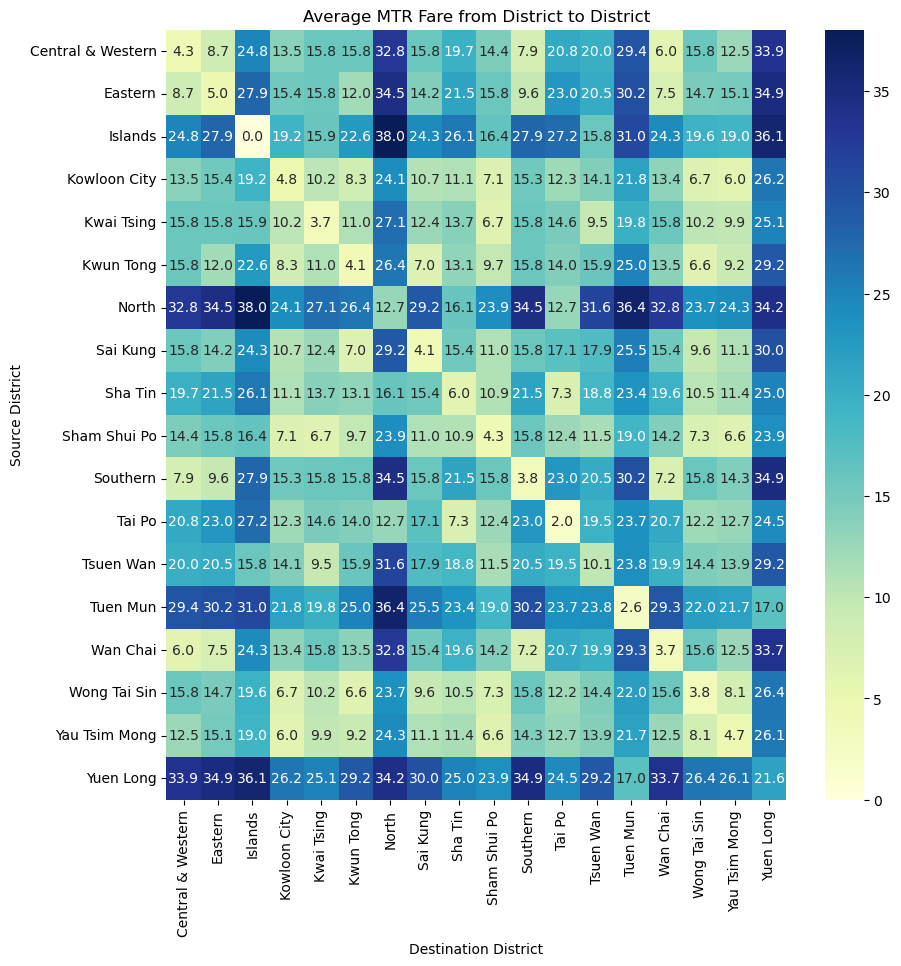

In [19]:
#Average fares from district to district
import seaborn as sns
import matplotlib.pyplot as plt


fare_matrix = mtr_routes.pivot_table(index='source_district',
                              columns='destination_district',
                              values='OCT_ADT_FARE',
                              aggfunc='mean')


plt.figure(figsize=(10, 10))
sns.heatmap(fare_matrix, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Average MTR Fare from District to District')
plt.xlabel('Destination District')
plt.ylabel('Source District')

After the EDA, we decided to remove Lo Wu and Lok Ma Chau, as they are border crossing stations that have a very high price compared to other stations

## Extra data cleaning and adding socioeconomic data

In [20]:
#Cleaning the data and adding socioeconomic data
mtr_routes = mtr_routes.replace("Central & Western", "Central and Western")

income_mtr_routes = mtr_routes.merge(sorted_df_economics_2022, left_on="source_district", right_on="dc_eng")
income_mtr_routes.rename(columns={'income median': 'start_income_median'}, inplace=True)
income_mtr_routes = income_mtr_routes.merge(sorted_df_economics_2022, left_on="destination_district", right_on="dc_eng")
income_mtr_routes.rename(columns={'income median': 'end_income_median'}, inplace=True)
socio_mtr_routes = income_mtr_routes.merge(sorted_df_population_density, left_on="source_district", right_on="DC_ENG")
socio_mtr_routes = socio_mtr_routes.drop(columns=['DC_ENG'])
socio_mtr_routes.rename(columns={'Population Density': 'start_population_density'}, inplace=True)
socio_mtr_routes = socio_mtr_routes.merge(sorted_df_population_density, left_on="destination_district", right_on="DC_ENG")
socio_mtr_routes = socio_mtr_routes.drop(columns=['DC_ENG'])
socio_mtr_routes.rename(columns={'Population Density': 'end_population_density'}, inplace=True)
socio_mtr_routes['to_higher_income'] = socio_mtr_routes['end_income_median'] > socio_mtr_routes['start_income_median']
socio_mtr_routes['to_lower_income'] = socio_mtr_routes['end_income_median'] < socio_mtr_routes['start_income_median']
socio_mtr_routes['to_equal_income'] = socio_mtr_routes['end_income_median'] == socio_mtr_routes['start_income_median']
socio_mtr_routes['to_higher_population'] = socio_mtr_routes['end_population_density'] > socio_mtr_routes['start_population_density']
socio_mtr_routes['to_lower_population'] = socio_mtr_routes['end_population_density'] < socio_mtr_routes['start_population_density']
socio_mtr_routes['to_equal_population'] = socio_mtr_routes['end_population_density'] == socio_mtr_routes['start_population_density']

In [21]:
#Removing Lo Wu and Lok Ma Chau
cleaned_mtr_routes = socio_mtr_routes[socio_mtr_routes['SRC_STATION_NAME'] != socio_mtr_routes['DEST_STATION_NAME']]
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Lo Wu']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Lok Ma Chau']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Lo Wu']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Lok Ma Chau']
cleaned_mtr_routes = cleaned_mtr_routes.drop(['source_longitude', 'source_latitude', 'destination_longitude', 'destination_latitude'], axis = 1)
cleaned_mtr_routes = cleaned_mtr_routes.drop(['SRC_STATION_NAME', 'DEST_STATION_NAME', 'start_income_median', 'end_income_median', 'start_population_density', 'end_population_density'], axis = 1)

In [22]:
cleaned_mtr_routes

,OCT_ADT_FARE,source_district,destination_district,distance_km,to_higher_income,to_lower_income,to_equal_income,to_higher_population,to_lower_population,to_equal_population
1,4.9,Central and Western,Central and Western,0.803734,False,False,True,False,False,True
2,10.6,Central and Western,Yau Tsim Mong,2.265852,False,True,False,True,False,False
3,10.6,Central and Western,Yau Tsim Mong,2.927723,False,True,False,True,False,False
4,13.2,Central and Western,Yau Tsim Mong,3.678339,False,True,False,True,False,False
5,13.2,Central and Western,Yau Tsim Mong,4.284403,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
9210,7.4,Southern,Wan Chai,5.127066,True,False,False,True,False,False
9211,17.1,Sha Tin,Wan Chai,9.114718,True,False,False,True,False,False
9212,13.2,Kowloon City,Wan Chai,5.922672,True,False,False,False,True,False
9213,13.2,Kowloon City,Wan Chai,5.143685,True,False,False,False,True,False


## Modeling on Routes

In [23]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
#If sklearn is not 1.6.1, then we need to install it
#Previous versions have an issue with linear regression
#Uncomment the below code to download it
#pip install scikit-learn==1.6.1

In [24]:
#One hot encoding
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


mtr_encoded = pd.get_dummies(cleaned_mtr_routes, columns=['source_district', 'destination_district'])

In [25]:
#Linear regression
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)


linear_regression_model = LinearRegression()


linear_regression_model.fit(X_train, y_train)


predictions = linear_regression_model.predict(X_test)
print("Intercept:", linear_regression_model.intercept_)


print('r_squared score : ', r2_score(y_test, predictions))
linear_r2 = r2_score(y_test, predictions)
feature_names = X_train.columns
linear_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_regression_model.coef_})
linear_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficients': linear_regression_model.coef_
})

Intercept: 5.797882644674866
r_squared score :  0.7714641728113008


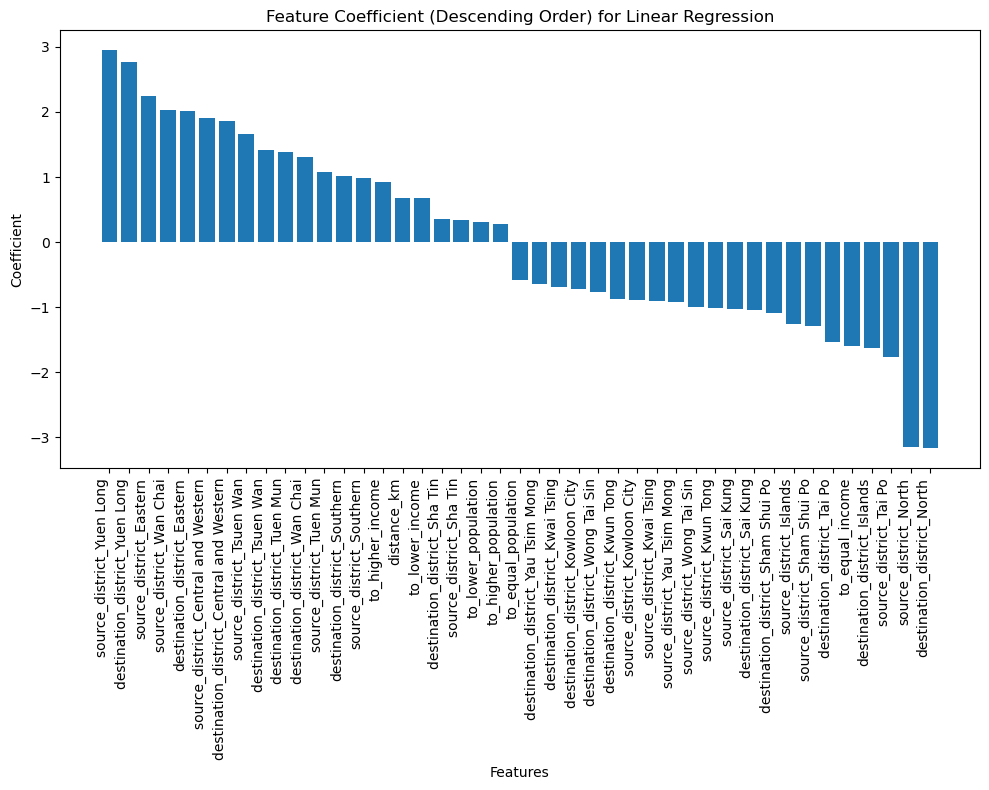

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df_sorted = linear_coefficients_df.sort_values('Coefficients', ascending=False)

plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Coefficients'])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Coefficient (Descending Order) for Linear Regression')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [27]:
#Linear SVR Model
from sklearn.svm import LinearSVR
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

linear_svr_model = LinearSVR()


linear_svr_model.fit(X_train, y_train)


linear_svr_coefficients = linear_svr_model.coef_


coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': linear_svr_coefficients})

predictions = linear_regression_model.predict(X_test)

print('r_squared score : ', r2_score(y_test, predictions))
linear_svr_r2 = r2_score(y_test, predictions)
feature_names = X_train.columns
linear_svr_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_svr_model.coef_})
svr_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficients': linear_svr_model.coef_
})

r_squared score :  0.7714641728113008


c:\Users\Winiera Sutanto\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


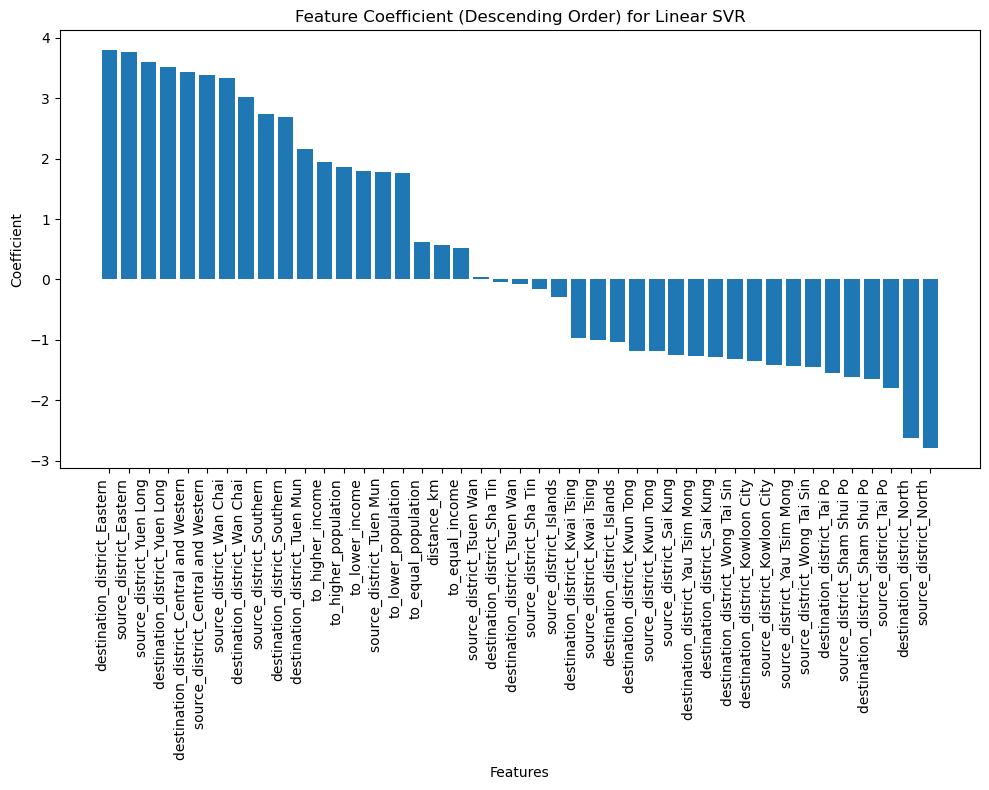

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


df_sorted = svr_coefficients_df.sort_values('Coefficients', ascending=False)


plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Coefficients'])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Coefficient (Descending Order) for Linear SVR')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [29]:
#Ridge regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

ridge_model = Ridge(alpha=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
ridge_model.fit(X_train, y_train)


y_pred = ridge_model.predict(X_test)


ridge_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {ridge_r2:.2f}')


coefficients = ridge_model.coef_

ridge_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.77


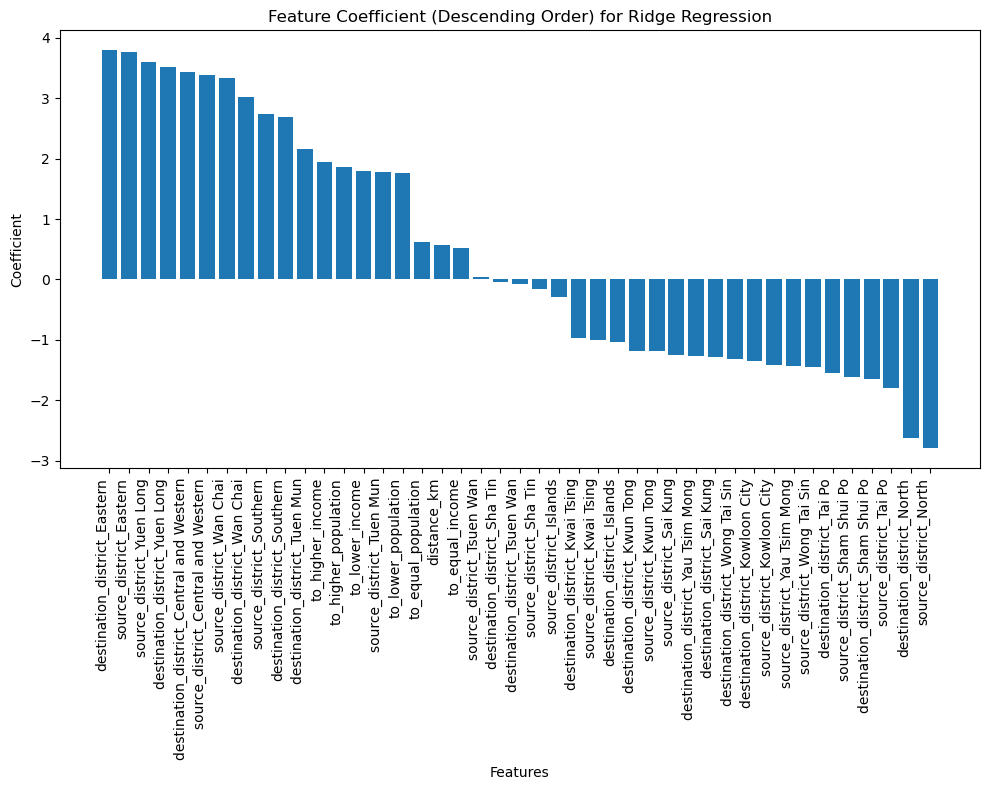

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


df_sorted = svr_coefficients_df.sort_values('Coefficients', ascending=False)


plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Coefficients'])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Coefficient (Descending Order) for Ridge Regression')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [31]:
#Lasso regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

lasso_model = Lasso(alpha=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
lasso_model.fit(X_train, y_train)


y_pred = lasso_model.predict(X_test)


lasso_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {lasso_r2:.2f}')


coefficients = lasso_model.coef_

lasso_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.69


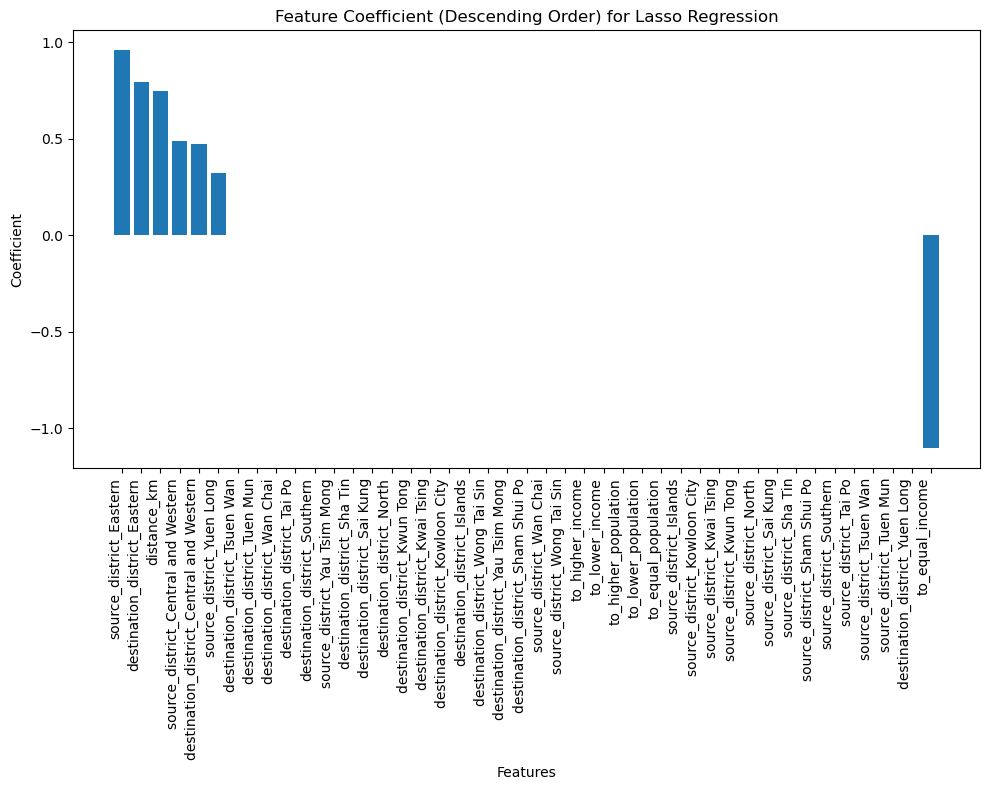

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


df_sorted = lasso_coefficients_df.sort_values('Coefficients', ascending=False)


plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Coefficients'])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Coefficient (Descending Order) for Lasso Regression')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [33]:
#Elastic Net Model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.3)
elastic_net_model.fit(X_train, y_train)


y_pred = elastic_net_model.predict(X_test)


elastic_net_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {elastic_net_r2:.2f}')


coefficients = elastic_net_model.coef_

elastic_net_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.71


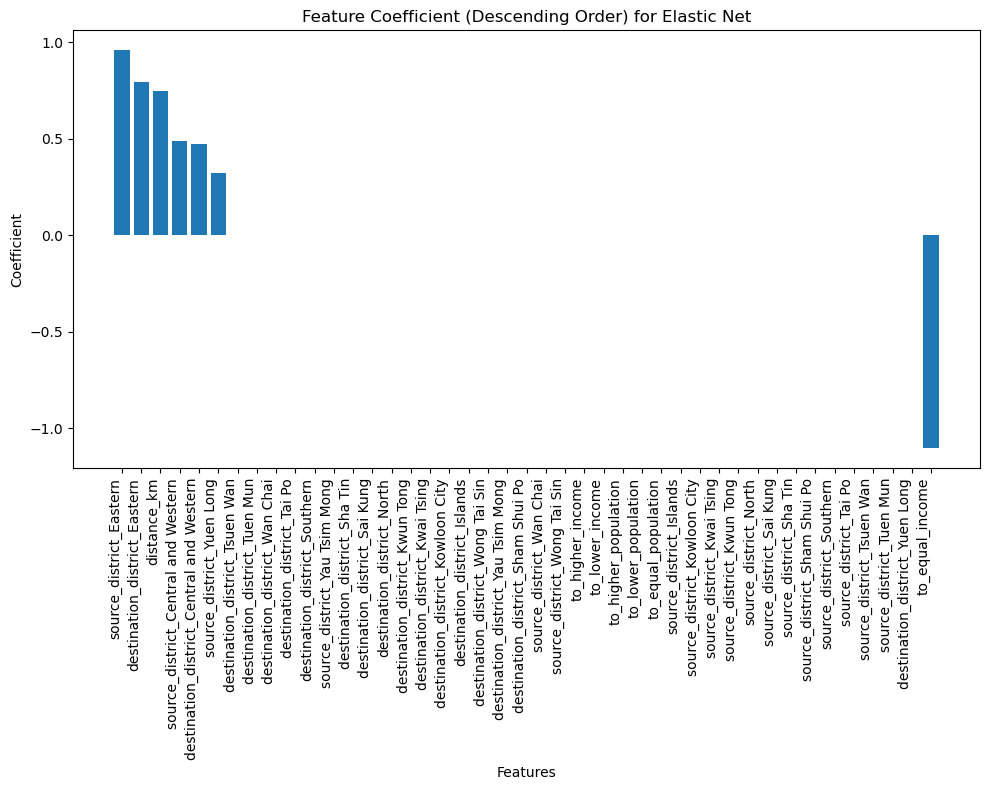

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


df_sorted = lasso_coefficients_df.sort_values('Coefficients', ascending=False)


plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Coefficients'])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Coefficient (Descending Order) for Elastic Net')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [35]:
#Random Forest Model
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


rf_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {rf_r2:.2f}')



feature_importances = rf_model.feature_importances_
rf_model_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

R² Score: 0.90


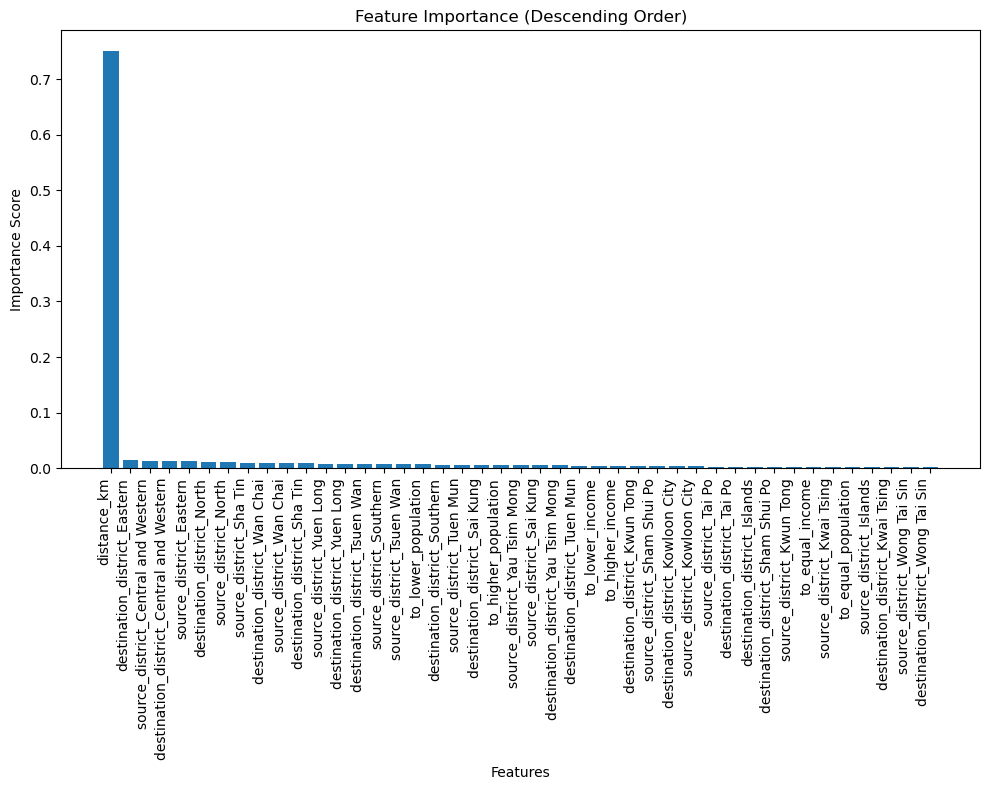

In [36]:
import pandas as pd
import matplotlib.pyplot as plt


df_sorted = rf_model_importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (Descending Order)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [37]:
#XGBoost Model
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


xgb_regressor = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.4, n_estimators=100)


xgb_regressor.fit(X_train, y_train)


preds = xgb_regressor.predict(X_test)


xgboost_r2 = r2_score(y_test, preds)
print(f'R² Score: {xgboost_r2:.2f}')


feature_importances = xgb_regressor.feature_importances_
xgboost_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

R² Score: 0.90


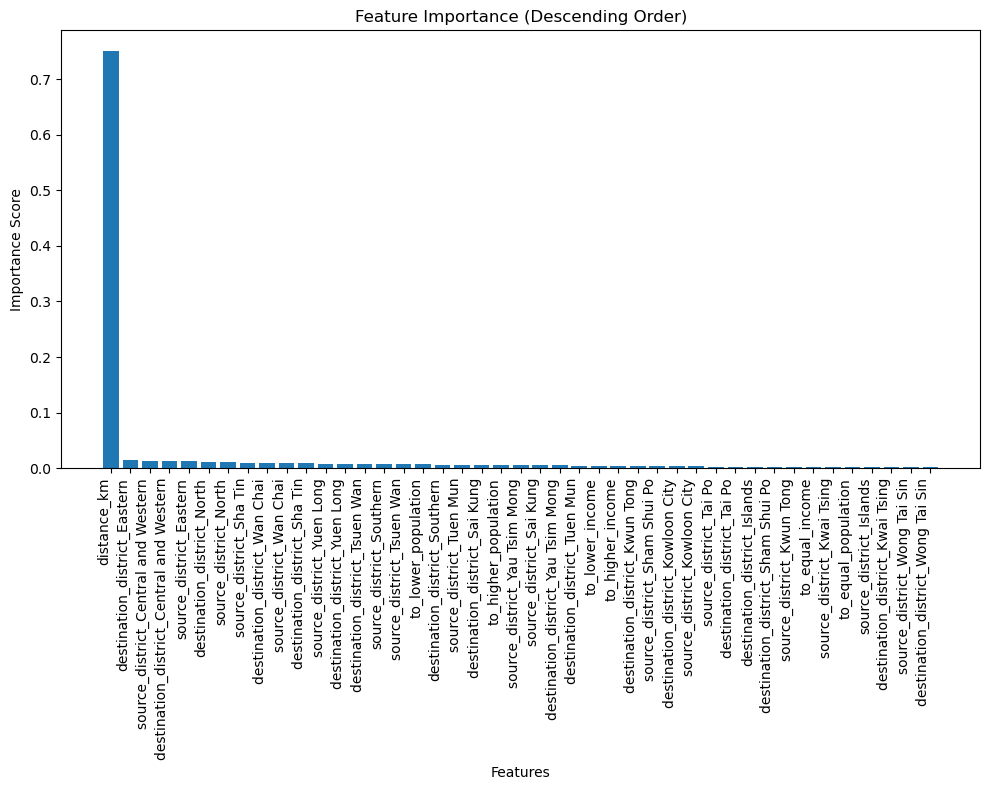

In [38]:
import pandas as pd
import matplotlib.pyplot as plt


df_sorted = rf_model_importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 8))
plt.bar(df_sorted['Feature'], df_sorted['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (Descending Order)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

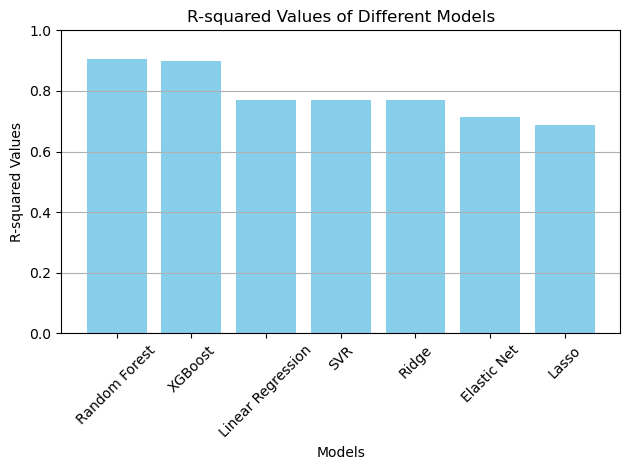

In [39]:
#Graph of R squared values
import matplotlib.pyplot as plt


models = ['Linear Regression', 'Random Forest', 'SVR', 'XGBoost', 'Ridge', 'Lasso', 'Elastic Net']
r_squared_values = [linear_r2, rf_r2, linear_svr_r2, xgboost_r2, ridge_r2, lasso_r2, elastic_net_r2]

data = list(zip(models, r_squared_values))


sorted_data = sorted(data, key=lambda x: x[1], reverse=True)


sorted_models, sorted_r_squared_values = zip(*sorted_data)


plt.bar(sorted_models, sorted_r_squared_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R-squared Values')
plt.title('R-squared Values of Different Models')
plt.ylim(0, 1)
plt.grid(axis='y')


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

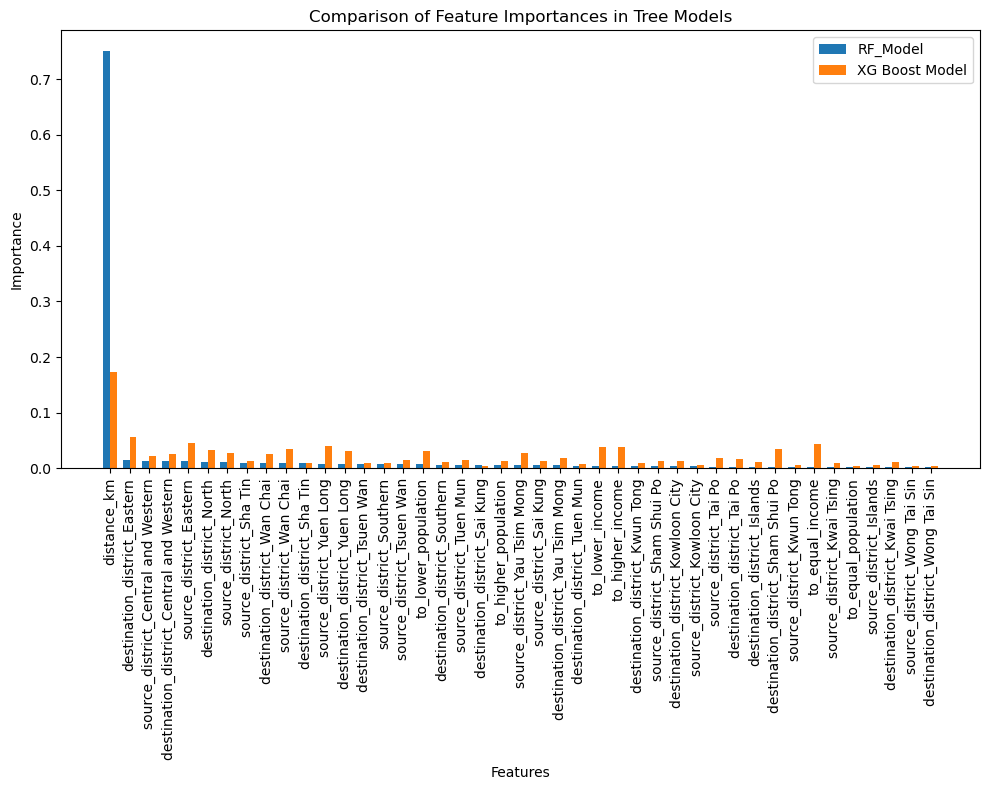

In [40]:
top_model1 = rf_model_importance_df.sort_values(by='Importance', ascending=False)
top_model2 = xgboost_importance_df.sort_values(by='Importance', ascending=False)


merged = pd.merge(top_model1, top_model2, on='Feature', suffixes=('_model1', '_model2'))


plt.figure(figsize=(10, 8))


bar_width = 0.35
index = range(len(merged))


plt.bar(index, merged['Importance_model1'], width=bar_width, label='RF_Model', align='center')
plt.bar([i + bar_width for i in index], merged['Importance_model2'], width=bar_width, label='XG Boost Model', align='center')


plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Comparison of Feature Importances in Tree Models')
plt.xticks([i + bar_width / 2 for i in index], merged['Feature'], rotation=90)
plt.legend()


plt.tight_layout()
plt.show()

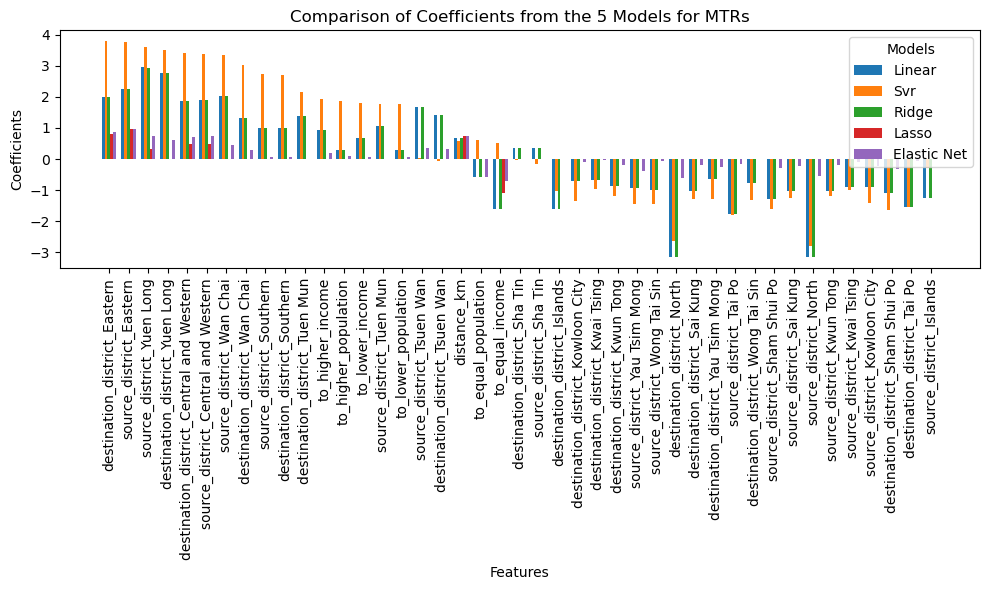

In [41]:

merged = linear_coefficients_df.rename(columns={'Coefficients': 'Coefficient_linear'})
merged = pd.merge(merged, svr_coefficients_df.rename(columns={'Coefficients': 'Coefficient_svr'}), on='Feature', how='outer')
merged = pd.merge(merged, ridge_coefficients_df.rename(columns={'Coefficients': 'Coefficient_ridge'}), on='Feature', how='outer')
merged = pd.merge(merged, lasso_coefficients_df.rename(columns={'Coefficients': 'Coefficient_lasso'}), on='Feature', how='outer')
merged = pd.merge(merged, elastic_net_coefficients_df.rename(columns={'Coefficients': 'Coefficient_elastic_net'}), on='Feature', how='outer')


merged['Max_Coefficient'] = merged[['Coefficient_linear', 'Coefficient_svr',
                                     'Coefficient_ridge', 'Coefficient_lasso',
                                     'Coefficient_elastic_net']].max(axis=1)


sorted_merged = merged.sort_values(by='Max_Coefficient', ascending=False)


plt.figure(figsize=(10, 6))


bar_width = 0.15
index = range(len(sorted_merged))


for i, model in enumerate(['linear', 'svr', 'ridge', 'lasso', 'elastic_net']):
    plt.bar([j + i * bar_width for j in index], sorted_merged[f'Coefficient_{model}'], width=bar_width, label=model.replace('_', ' ').title())


plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Comparison of Coefficients from the 5 Models for MTRs')


plt.xticks([j + 2 * bar_width for j in index], sorted_merged['Feature'], rotation=90)


plt.legend(title='Models')


plt.tight_layout()
plt.show()

## Predicting on Routes

In [42]:
mtr_encoded = pd.get_dummies(cleaned_mtr_routes, columns=['source_district', 'destination_district'])

In [43]:
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

xgboost_predict = xgb_regressor.predict(X)

In [44]:
xgboost_predicted_socio = cleaned_mtr_routes.copy()
xgboost_predicted_socio['prediction_fare'] = xgboost_predict

In [45]:
from scipy import stats


xgboost_predicted_socio['fare_diff'] = xgboost_predicted_socio['OCT_ADT_FARE'] - xgboost_predicted_socio['prediction_fare']

Q1 = xgboost_predicted_socio["fare_diff"].quantile(0.25)
Q3 = xgboost_predicted_socio["fare_diff"].quantile(0.75)
IQR = Q3 - Q1
UB = Q3 + 1.5 * IQR

xgboost_predicted_socio["Is_Overpriced"] = xgboost_predicted_socio["fare_diff"] > UB

In [46]:
import pandas as pd


district_counts = xgboost_predicted_socio['source_district'].value_counts().reset_index()
district_counts.columns = ['district', 'district_count']

expensive_district_counts = xgboost_predicted_socio.groupby("source_district")["Is_Overpriced"].sum().reset_index()
expensive_district_counts.columns = ['district', 'expensive_count']

percentage = pd.merge(district_counts, expensive_district_counts, on='district')
percentage['percentage_expensive'] = (percentage['expensive_count'] / percentage['district_count']) * 100

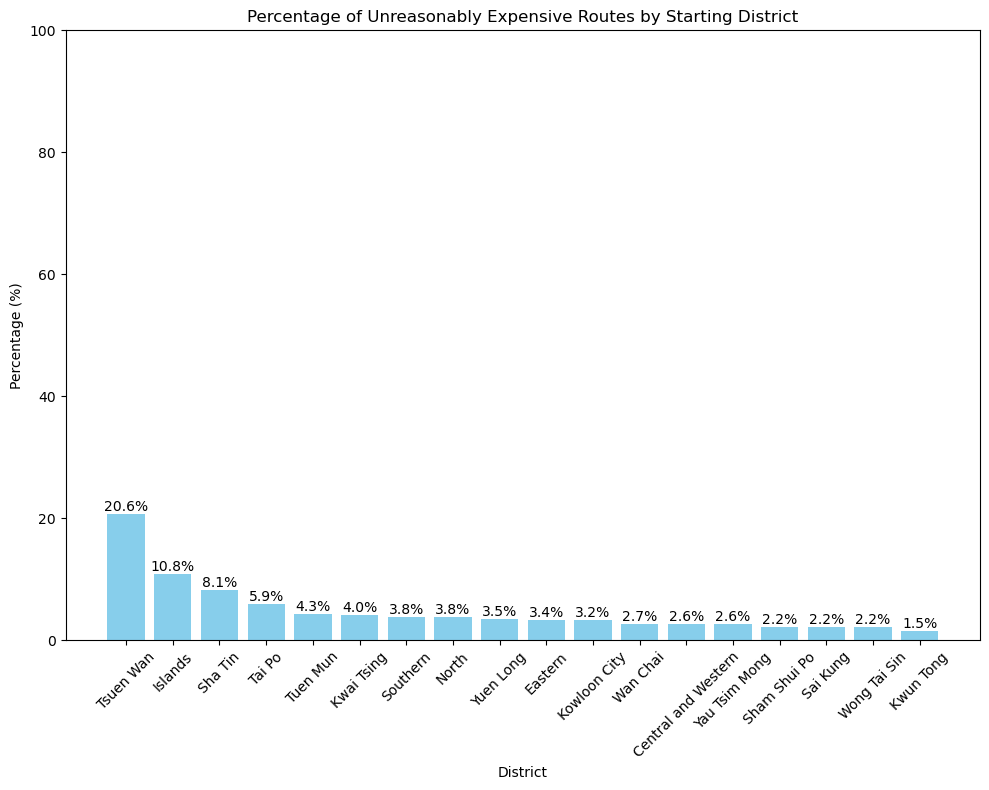

In [47]:
import matplotlib.pyplot as plt


result_df = percentage.sort_values('percentage_expensive', ascending=False)


plt.figure(figsize=(10, 8))
bars = plt.bar(result_df['district'], result_df['percentage_expensive'], color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')


plt.title('Percentage of Unreasonably Expensive Routes by Starting District')
plt.xlabel('District')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

## Modelling  Revision

The above results obtained have issues in distance calculation because we used straight line calculation, which causes some issues with certain routes. We then used edge distance calculations to get a more accurate representation.

In [48]:
mtr_routes = mtr_routes.drop(columns=['distance_km'])
mtr_routes = pd.merge(
    mtr_routes,
    mtr_edge_distances,
    on=['SRC_STATION_NAME', 'DEST_STATION_NAME'],
    how='left'
)

In [49]:
mtr_routes = mtr_routes.replace("Central & Western", "Central and Western")

income_mtr_routes = mtr_routes.merge(sorted_df_economics_2022, left_on="source_district", right_on="dc_eng")
income_mtr_routes.rename(columns={'income median': 'start_income_median'}, inplace=True)
income_mtr_routes = income_mtr_routes.merge(sorted_df_economics_2022, left_on="destination_district", right_on="dc_eng")
income_mtr_routes.rename(columns={'income median': 'end_income_median'}, inplace=True)
socio_mtr_routes = income_mtr_routes.merge(sorted_df_population_density, left_on="source_district", right_on="DC_ENG")
socio_mtr_routes = socio_mtr_routes.drop(columns=['DC_ENG'])
socio_mtr_routes.rename(columns={'Population Density': 'start_population_density'}, inplace=True)
socio_mtr_routes = socio_mtr_routes.merge(sorted_df_population_density, left_on="destination_district", right_on="DC_ENG")
socio_mtr_routes = socio_mtr_routes.drop(columns=['DC_ENG'])
socio_mtr_routes.rename(columns={'Population Density': 'end_population_density'}, inplace=True)
socio_mtr_routes['to_higher_income'] = socio_mtr_routes['end_income_median'] > socio_mtr_routes['start_income_median']
socio_mtr_routes['to_lower_income'] = socio_mtr_routes['end_income_median'] < socio_mtr_routes['start_income_median']
socio_mtr_routes['to_equal_income'] = socio_mtr_routes['end_income_median'] == socio_mtr_routes['start_income_median']
socio_mtr_routes['to_higher_population'] = socio_mtr_routes['end_population_density'] > socio_mtr_routes['start_population_density']
socio_mtr_routes['to_lower_population'] = socio_mtr_routes['end_population_density'] < socio_mtr_routes['start_population_density']
socio_mtr_routes['to_equal_population'] = socio_mtr_routes['end_population_density'] == socio_mtr_routes['start_population_density']

In [50]:
cleaned_mtr_routes = socio_mtr_routes[socio_mtr_routes['SRC_STATION_NAME'] != socio_mtr_routes['DEST_STATION_NAME']]
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Lo Wu']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Lok Ma Chau']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Lo Wu']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Lok Ma Chau']
cleaned_mtr_routes = cleaned_mtr_routes.drop(['source_longitude', 'source_latitude', 'destination_longitude', 'destination_latitude'], axis = 1)
cleaned_mtr_routes = cleaned_mtr_routes.drop(['SRC_STATION_NAME', 'DEST_STATION_NAME', 'start_income_median', 'end_income_median', 'start_population_density', 'end_population_density'], axis = 1)

## Modeling on Routes Revised

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

mtr_encoded = pd.get_dummies(cleaned_mtr_routes, columns=['source_district', 'destination_district'])

In [52]:
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)


linear_regression_model = LinearRegression()


linear_regression_model.fit(X_train, y_train)


predictions = linear_regression_model.predict(X_test)
print("Intercept:", linear_regression_model.intercept_)


print('r_squared score : ', r2_score(y_test, predictions))
linear_r2 = r2_score(y_test, predictions)
feature_names = X_train.columns
linear_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_regression_model.coef_})
linear_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficients': linear_regression_model.coef_
})

Intercept: 3.5617219658569557
r_squared score :  0.8049391538056649


In [53]:
#Linear SVR Model
from sklearn.svm import LinearSVR
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

linear_svr_model = LinearSVR()


linear_svr_model.fit(X_train, y_train)


linear_svr_coefficients = linear_svr_model.coef_


coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': linear_svr_coefficients})

predictions = linear_regression_model.predict(X_test)

print('r_squared score : ', r2_score(y_test, predictions))
linear_svr_r2 = r2_score(y_test, predictions)
feature_names = X_train.columns
linear_svr_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_svr_model.coef_})
svr_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficients': linear_svr_model.coef_
})

r_squared score :  0.8049391538056649


c:\Users\Winiera Sutanto\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [54]:
#Ridge regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

ridge_model = Ridge(alpha=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
ridge_model.fit(X_train, y_train)


y_pred = ridge_model.predict(X_test)


ridge_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {ridge_r2:.2f}')


coefficients = ridge_model.coef_

ridge_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.80


In [55]:
#Lasso regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

lasso_model = Lasso(alpha=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
lasso_model.fit(X_train, y_train)


y_pred = lasso_model.predict(X_test)


lasso_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {lasso_r2:.2f}')


coefficients = lasso_model.coef_

lasso_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.71


In [56]:
#Elastic Net Model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.3)
elastic_net_model.fit(X_train, y_train)


y_pred = elastic_net_model.predict(X_test)


elastic_net_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {elastic_net_r2:.2f}')


coefficients = elastic_net_model.coef_

elastic_net_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.74


In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


rf_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {rf_r2:.2f}')



feature_importances = rf_model.feature_importances_
rf_model_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

R² Score: 0.92


In [58]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


xgb_regressor = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.4, n_estimators=100)


xgb_regressor.fit(X_train, y_train)


preds = xgb_regressor.predict(X_test)


xgboost_r2 = r2_score(y_test, preds)
print(f'R² Score: {xgboost_r2:.2f}')

feature_importances = xgb_regressor.feature_importances_
xgboost_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

R² Score: 0.92


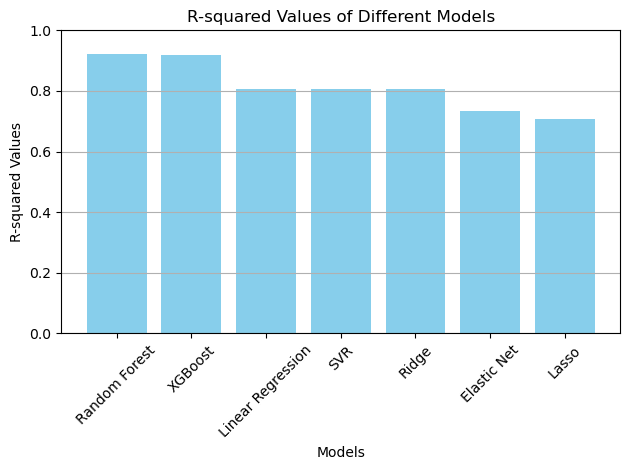

In [59]:
#Graph of R squared values
import matplotlib.pyplot as plt


models = ['Linear Regression', 'Random Forest', 'SVR', 'XGBoost', 'Ridge', 'Lasso', 'Elastic Net']
r_squared_values = [linear_r2, rf_r2, linear_svr_r2, xgboost_r2, ridge_r2, lasso_r2, elastic_net_r2]

data = list(zip(models, r_squared_values))


sorted_data = sorted(data, key=lambda x: x[1], reverse=True)


sorted_models, sorted_r_squared_values = zip(*sorted_data)


plt.bar(sorted_models, sorted_r_squared_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R-squared Values')
plt.title('R-squared Values of Different Models')
plt.ylim(0, 1)
plt.grid(axis='y')


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

## Predicting on Routes Revised

In [60]:
mtr_encoded = pd.get_dummies(cleaned_mtr_routes, columns=['source_district', 'destination_district'])

In [61]:
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

xgboost_predict = xgb_regressor.predict(X)

In [62]:
xgboost_predicted_socio = cleaned_mtr_routes.copy()
xgboost_predicted_socio['prediction_fare'] = xgboost_predict

In [63]:
from scipy import stats


xgboost_predicted_socio['fare_diff'] = xgboost_predicted_socio['OCT_ADT_FARE'] - xgboost_predicted_socio['prediction_fare']


Q1 = xgboost_predicted_socio["fare_diff"].quantile(0.25)
Q3 = xgboost_predicted_socio["fare_diff"].quantile(0.75)
IQR = Q3 - Q1
UB = Q3 + 1.5 * IQR

xgboost_predicted_socio["Is_Overpriced"] = xgboost_predicted_socio["fare_diff"] > UB

In [64]:
import pandas as pd


district_counts = xgboost_predicted_socio['source_district'].value_counts().reset_index()
district_counts.columns = ['district', 'district_count']

expensive_district_counts = xgboost_predicted_socio.groupby("source_district")["Is_Overpriced"].sum().reset_index()
expensive_district_counts.columns = ['district', 'expensive_count']

percentage = pd.merge(district_counts, expensive_district_counts, on='district')
percentage['percentage_expensive'] = (percentage['expensive_count'] / percentage['district_count']) * 100

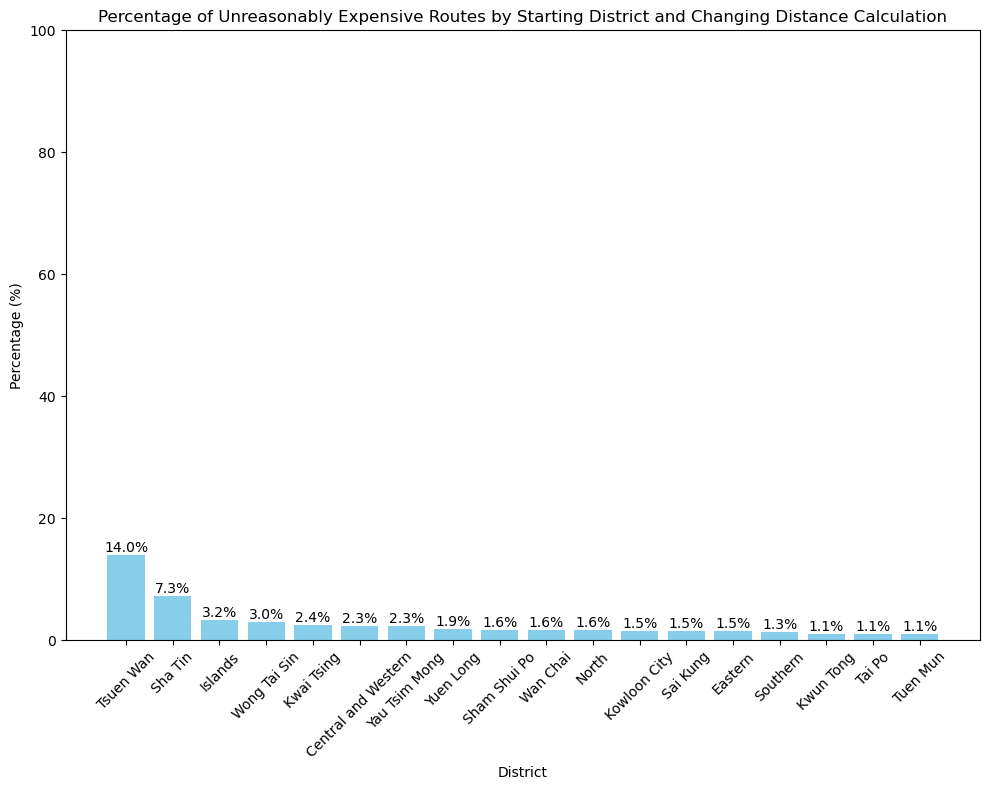

In [65]:
import matplotlib.pyplot as plt


result_df = percentage.sort_values('percentage_expensive', ascending=False)


plt.figure(figsize=(10, 8))
bars = plt.bar(result_df['district'], result_df['percentage_expensive'], color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')


plt.title('Percentage of Unreasonably Expensive Routes by Starting District and Changing Distance Calculation')
plt.xlabel('District')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

After further analysis, the reason Tsuen Wan has a high percentage is because of Sunny Bay and Disnelyand station which are in the Tsuen Wan district. The reason Sha Ting has a higher percentage is due to Racecourse station, which is only open on race days. We then removed these stations from the routes

## Removing Disneyland and Racecourse

In [66]:
mtr_routes = mtr_routes.drop(columns=['distance_km'])
mtr_routes = pd.merge(
    mtr_routes,
    mtr_edge_distances,
    on=['SRC_STATION_NAME', 'DEST_STATION_NAME'],
    how='left'
)

In [67]:
mtr_routes = mtr_routes.replace("Central & Western", "Central and Western")

income_mtr_routes = mtr_routes.merge(sorted_df_economics_2022, left_on="source_district", right_on="dc_eng")
income_mtr_routes.rename(columns={'income median': 'start_income_median'}, inplace=True)
income_mtr_routes = income_mtr_routes.merge(sorted_df_economics_2022, left_on="destination_district", right_on="dc_eng")
income_mtr_routes.rename(columns={'income median': 'end_income_median'}, inplace=True)
socio_mtr_routes = income_mtr_routes.merge(sorted_df_population_density, left_on="source_district", right_on="DC_ENG")
socio_mtr_routes = socio_mtr_routes.drop(columns=['DC_ENG'])
socio_mtr_routes.rename(columns={'Population Density': 'start_population_density'}, inplace=True)
socio_mtr_routes = socio_mtr_routes.merge(sorted_df_population_density, left_on="destination_district", right_on="DC_ENG")
socio_mtr_routes = socio_mtr_routes.drop(columns=['DC_ENG'])
socio_mtr_routes.rename(columns={'Population Density': 'end_population_density'}, inplace=True)
socio_mtr_routes['to_higher_income'] = socio_mtr_routes['end_income_median'] > socio_mtr_routes['start_income_median']
socio_mtr_routes['to_lower_income'] = socio_mtr_routes['end_income_median'] < socio_mtr_routes['start_income_median']
socio_mtr_routes['to_equal_income'] = socio_mtr_routes['end_income_median'] == socio_mtr_routes['start_income_median']
socio_mtr_routes['to_higher_population'] = socio_mtr_routes['end_population_density'] > socio_mtr_routes['start_population_density']
socio_mtr_routes['to_lower_population'] = socio_mtr_routes['end_population_density'] < socio_mtr_routes['start_population_density']
socio_mtr_routes['to_equal_population'] = socio_mtr_routes['end_population_density'] == socio_mtr_routes['start_population_density']

In [68]:
cleaned_mtr_routes = socio_mtr_routes[socio_mtr_routes['SRC_STATION_NAME'] != socio_mtr_routes['DEST_STATION_NAME']]
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Lo Wu']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Lok Ma Chau']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Lo Wu']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Lok Ma Chau']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Disneyland Resort']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Disneyland Resort']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['SRC_STATION_NAME'] != 'Racecourse']
cleaned_mtr_routes = cleaned_mtr_routes[cleaned_mtr_routes['DEST_STATION_NAME'] != 'Racecourse']
cleaned_mtr_routes = cleaned_mtr_routes.drop(['source_longitude', 'source_latitude', 'destination_longitude', 'destination_latitude'], axis = 1)
cleaned_mtr_routes = cleaned_mtr_routes.drop(['SRC_STATION_NAME', 'DEST_STATION_NAME', 'start_income_median', 'end_income_median', 'start_population_density', 'end_population_density'], axis = 1)

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

mtr_encoded = pd.get_dummies(cleaned_mtr_routes, columns=['source_district', 'destination_district'])

In [70]:
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)


linear_regression_model = LinearRegression()


linear_regression_model.fit(X_train, y_train)


predictions = linear_regression_model.predict(X_test)
print("Intercept:", linear_regression_model.intercept_)


print('r_squared score : ', r2_score(y_test, predictions))
linear_r2 = r2_score(y_test, predictions)
feature_names = X_train.columns
linear_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_regression_model.coef_})
linear_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficients': linear_regression_model.coef_
})

Intercept: 4.131372621172407
r_squared score :  0.8375503772985288


In [71]:
#Linear SVR Model
from sklearn.svm import LinearSVR
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

linear_svr_model = LinearSVR()


linear_svr_model.fit(X_train, y_train)


linear_svr_coefficients = linear_svr_model.coef_


coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': linear_svr_coefficients})

predictions = linear_regression_model.predict(X_test)

print('r_squared score : ', r2_score(y_test, predictions))
linear_svr_r2 = r2_score(y_test, predictions)
feature_names = X_train.columns
linear_svr_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_svr_model.coef_})
svr_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficients': linear_svr_model.coef_
})

r_squared score :  0.8375503772985288


c:\Users\Winiera Sutanto\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [72]:
#Ridge regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

ridge_model = Ridge(alpha=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
ridge_model.fit(X_train, y_train)


y_pred = ridge_model.predict(X_test)


ridge_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {ridge_r2:.2f}')


coefficients = ridge_model.coef_

ridge_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.84


In [73]:
#Lasso regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

lasso_model = Lasso(alpha=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
lasso_model.fit(X_train, y_train)


y_pred = lasso_model.predict(X_test)


lasso_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {lasso_r2:.2f}')


coefficients = lasso_model.coef_

lasso_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.75


In [74]:
#Elastic Net Model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.3)
elastic_net_model.fit(X_train, y_train)


y_pred = elastic_net_model.predict(X_test)


elastic_net_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {elastic_net_r2:.2f}')


coefficients = elastic_net_model.coef_

elastic_net_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficients': coefficients
})

R² Score: 0.77


In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


rf_r2 = r2_score(y_test, y_pred)
print(f'R² Score: {rf_r2:.2f}')



feature_importances = rf_model.feature_importances_
rf_model_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

R² Score: 0.96


In [76]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


xgb_regressor = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.4, n_estimators=100)


xgb_regressor.fit(X_train, y_train)


preds = xgb_regressor.predict(X_test)


xgboost_r2 = r2_score(y_test, preds)
print(f'R² Score: {xgboost_r2:.2f}')


feature_importances = xgb_regressor.feature_importances_
xgboost_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

R² Score: 0.96


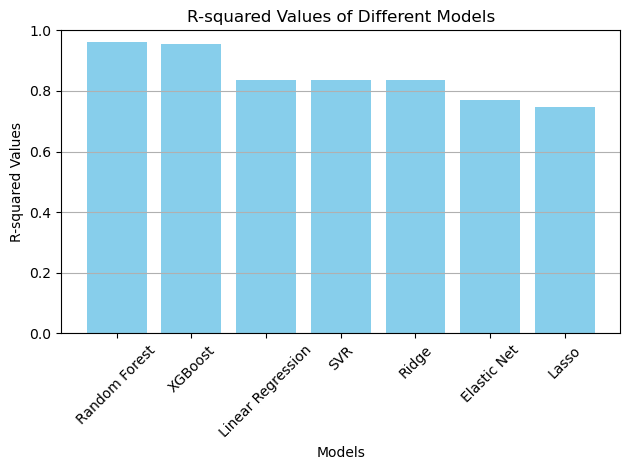

In [77]:
#Graph of R squared values
import matplotlib.pyplot as plt


models = ['Linear Regression', 'Random Forest', 'SVR', 'XGBoost', 'Ridge', 'Lasso', 'Elastic Net']
r_squared_values = [linear_r2, rf_r2, linear_svr_r2, xgboost_r2, ridge_r2, lasso_r2, elastic_net_r2]

data = list(zip(models, r_squared_values))


sorted_data = sorted(data, key=lambda x: x[1], reverse=True)


sorted_models, sorted_r_squared_values = zip(*sorted_data)


plt.bar(sorted_models, sorted_r_squared_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R-squared Values')
plt.title('R-squared Values of Different Models')
plt.ylim(0, 1)
plt.grid(axis='y')


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [78]:
X = mtr_encoded.drop(['OCT_ADT_FARE'], axis = 1)
y = mtr_encoded['OCT_ADT_FARE']

xgboost_predict = xgb_regressor.predict(X)

In [79]:
xgboost_predicted_socio = cleaned_mtr_routes.copy()
xgboost_predicted_socio['prediction_fare'] = xgboost_predict

In [80]:
from scipy import stats


xgboost_predicted_socio['fare_diff'] = xgboost_predicted_socio['OCT_ADT_FARE'] - xgboost_predicted_socio['prediction_fare']


Q1 = xgboost_predicted_socio["fare_diff"].quantile(0.25)
Q3 = xgboost_predicted_socio["fare_diff"].quantile(0.75)
IQR = Q3 - Q1
UB = Q3 + 1.5 * IQR

xgboost_predicted_socio["Is_Overpriced"] = xgboost_predicted_socio["fare_diff"] > UB

In [81]:
import pandas as pd


district_counts = xgboost_predicted_socio['source_district'].value_counts().reset_index()
district_counts.columns = ['district', 'district_count']

expensive_district_counts = xgboost_predicted_socio.groupby("source_district")["Is_Overpriced"].sum().reset_index()
expensive_district_counts.columns = ['district', 'expensive_count']

percentage = pd.merge(district_counts, expensive_district_counts, on='district')
percentage['percentage_expensive'] = (percentage['expensive_count'] / percentage['district_count']) * 100

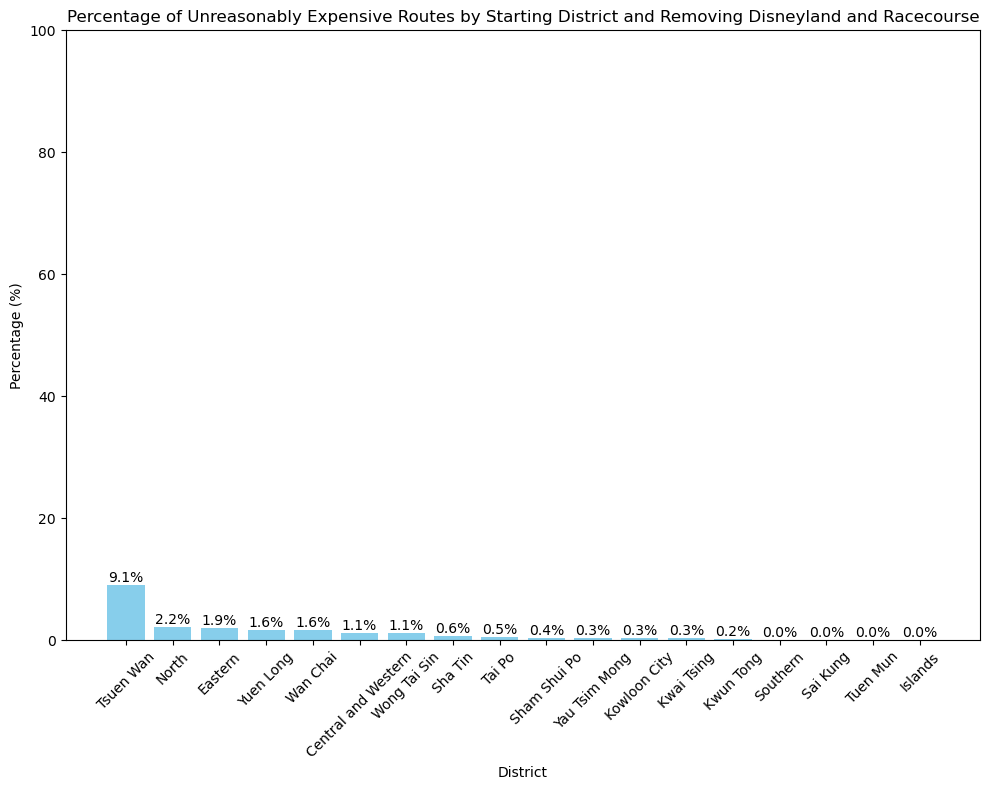

In [82]:
import matplotlib.pyplot as plt


result_df = percentage.sort_values('percentage_expensive', ascending=False)


plt.figure(figsize=(10, 8))
bars = plt.bar(result_df['district'], result_df['percentage_expensive'], color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')


plt.title('Percentage of Unreasonably Expensive Routes by Starting District and Removing Disneyland and Racecourse')
plt.xlabel('District')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Set y-axis limit to 0-100% for percentages

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

The reason Tsuen Wan district has a higher percentage is due to Sunny Bay station being in that district. Since it has to cross islands, it is more expensive